In [1]:
import sys
import warnings

from typing import Optional

import os
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, to_rgba
import mapclassify as mc

In [ ]:
BASE_PATH = os.path.join("D:\\", "Workspaces", "vscode-workspace", "ai_x_medicine", "data")
INPUT_PAIN_PATH = os.path.join(BASE_PATH, "out", "socioeconomic-pain-sov.csv")
# Projections map (easy names -> EPSG/PROJ strings)
PROJECTIONS = {
    "PlateCarree": "EPSG:4326",
    "Mercator": "EPSG:3395",
    "Robinson": "+proj=robin +lon_0=0 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs",
    "Mollweide": "+proj=moll +lon_0=0 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs",
    "EqualEarth": "+proj=eqearth +lon_0=0 +datum=WGS84 +units=m +no_defs",
    "WinkelTripel": "+proj=wintri +lon_0=0 +datum=WGS84 +units=m +no_defs",
}
USED_PROJECTION = "PlateCarree"
CODE_COLUMN = "SOV_A3"

In [3]:
def load_world(verbose: bool = False):
    # Use Natural Earth low-res that ships with GeoPandas
    #world_path = gpd.datasets.get_path("naturalearth_lowres")
    world = gpd.read_file(os.path.join(BASE_PATH, "countries_map.zip"))#"https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip")
    #world = gpd.read_file("https://naciscdn.org/naturalearth/110m/physical/ne_110m_land.zip") #geodatasets.get_path("naturalearth_lowres"))
    if verbose: 
        print(world)
    # Fix some known ISO code quirks
    # Natural Earth uses "France" overseas territories as single polygon, ISO A3 is in 'iso_a3'
    world.loc[world["SOVEREIGNT"] == "France", "sov_a3"] = "FRA"
    world.loc[world["SOVEREIGNT"] == "Norway", "sov_a3"] = "NOR"
    world.loc[world["SOVEREIGNT"] == "Somaliland", "sov_a3"] = "SOL"  # non-ISO, avoid collision
    return world

In [4]:
def classify_values(series, scheme, k):
    scheme = (scheme or "").lower()
    if scheme in ("quantiles", "quantile", "q"):
        return mc.Quantiles(series, k=k)
    elif scheme in ("equal_interval", "equalinterval", "equal", "ei"):
        return mc.EqualInterval(series, k=k)
    elif scheme in ("natural_breaks", "jenks", "nb"):
        return mc.NaturalBreaks(series, k=k)
    elif scheme in ("std_mean", "std", "zscore"):
        return mc.StdMean(series)
    else:
        return None  # continuous

In [5]:
# commented args

    #parser = argparse.ArgumentParser(description="Color a world map by country and export PNG.")
    #parser.add_argument("--code-col", default="iso_a3", help="Column with ISO-3 codes (default: iso_a3)")
    #parser.add_argument("--value-col", default="value", help="Numeric value column (default: value)")
    #parser.add_argument("--name-col", default=None, help="Optional column with custom country labels")
    #parser.add_argument("--title", default=None, help="Optional map title")
    #parser.add_argument("--cmap", default="viridis", help="Matplotlib colormap name")
    #parser.add_argument("--missing-color", default="#EEEEEE", help="Color for countries without data")
    #parser.add_argument("--edge-color", default="#FFFFFF", help="Country border line color")
    #parser.add_argument("--edge-width", type=float, default=0.25, help="Country border line width")
    # parser.add_argument("--projection", default="Robinson", choices=list(PROJECTIONS.keys()), help="Map projection")
    # parser.add_argument("--dpi", type=int, default=300, help="Output DPI")
    #parser.add_argument("--width", type=float, default=12, help="Figure width in inches")
    #parser.add_argument("--height", type=float, default=6.5, help="Figure height in inches")
    #parser.add_argument("--scheme", default=None, help="Classification scheme: quantiles, equal_interval, natural_breaks, std_mean")
    #parser.add_argument("--k", type=int, default=5, help="Number of classes (if scheme is given)")
    #parser.add_argument("--legend", action="store_true", help="Show legend")
    #parser.add_argument("--legend-title", default=None, help="Legend title")
    #parser.add_argument("--label-topn", type=int, default=0, help="Label top-N countries by value (0=none)")
    #parser.add_argument("--format-values", default=".2f", help="Format string for labels/legend (default: .2f)")

Index(['featurecla', 'scalerank', 'LABELRANK', 'SOVEREIGNT', 'SOV_A3',
       'ADM0_DIF', 'LEVEL', 'TYPE', 'TLC', 'ADMIN',
       ...
       'FCLASS_ID', 'FCLASS_PL', 'FCLASS_GR', 'FCLASS_IT', 'FCLASS_NL',
       'FCLASS_SE', 'FCLASS_BD', 'FCLASS_UA', 'geometry', 'sov_a3'],
      dtype='object', length=170)


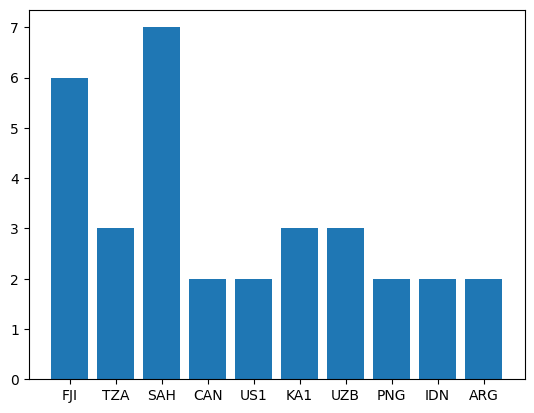

In [6]:
world = load_world(verbose=False)
df_world = pd.DataFrame(world)
#print(df_world["LABELRANK"])
#print(df_world["SOV_A3"])
num_elements = 10
plt.bar(df_world["SOV_A3"][:num_elements], df_world["LABELRANK"][:num_elements])
#df_world["LABELRANK"][0:10].plot(kind="bar", xlabel=df_world["SOV_A3"][0:10])
print(df_world.columns)

In [7]:
label_topn = 3
args_edge_width = 0.25
args_edge_color, args_missing_color, args_cmap = "#FFFFFF", "#EEEEEE", "YlOrRd"
DPI_VALUE = 100
HEIGHT_VALUE = 128
WIDTH_VALUE = int(HEIGHT_VALUE * 16 / 9)

In [ ]:
def generate_map(dataframe: pd.DataFrame, output_path: Optional[str] = None, args_value_col: str = "value", args_code_col = "sov_a3"):
    if output_path is None: output_path = os.path.join("..", "data", "world.png")

    # Load data
    if args_code_col not in dataframe.columns or args_value_col not in dataframe.columns:
        print(f"CSV must include columns '{args_code_col}' and '{args_value_col}'", file=sys.stderr)
        return

    # Clean codes
    dataframe[args_code_col] = dataframe[args_code_col].astype(str).str.upper().str.strip()

    # Load world geometries
    world = load_world()

    # Merge
    merged = world.merge(dataframe[[args_code_col, args_value_col]], left_on=CODE_COLUMN, right_on=args_code_col, how="left")

    # Warn about codes that didn't match
    provided_codes = set(dataframe[args_code_col].unique())
    matched_codes = set(merged.loc[~merged[args_value_col].isna(), CODE_COLUMN].unique())
    missing_codes = sorted(provided_codes - matched_codes)
    if missing_codes:
        warnings.warn(f"{len(missing_codes)} code(s) in your CSV did not match Natural Earth {CODE_COLUMN}: {missing_codes}")

    # Projection
    try:
        merged = merged.to_crs(PROJECTIONS.get(USED_PROJECTION))
    except Exception as e:
        warnings.warn(f"Could not project to {USED_PROJECTION}, using PlateCarree. Error: {e}")
        merged = merged.to_crs(PROJECTIONS["PlateCarree"])
    
    cmap = plt.get_cmap(args_cmap)
    column_to_plot = args_value_col
    legend_kwds = {"loc": "lower left", "title": "TODO", "fmt": ".2f"}

    # Plot
    fig = plt.figure(figsize=(WIDTH_VALUE, HEIGHT_VALUE), dpi=DPI_VALUE)
    ax = plt.gca()
    fig.patch.set_alpha(0)

    plot_kwargs = dict(
        column=column_to_plot,
        cmap=cmap,
        linewidth=args_edge_width,
        edgecolor=args_edge_color,
        missing_kwds={"color": args_missing_color, "edgecolor": args_edge_color, "hatch": None, "linewidth": args_edge_width},
    )
    #merged.plot(ax=ax, **plot_kwargs)
    merged.plot(column="value", ax=ax, cmap=args_cmap)

    ax.set_axis_off()
    ax.set_aspect("equal")

    ax.set_title("TODO Title", fontsize=14, pad=12)

    """
    # geopandas legend for continuous data is limited; we use built-in
    merged.plot(ax=ax, **plot_kwargs, legend=True, legend_kwds=legend_kwds)

    # Label top-N countries
    try:
        # Compute centroids in projected CRS for good placement
        centroids = merged.copy()
        centroids["centroid"] = centroids.geometry.centroid
        top = centroids.nlargest(label_topn, args_value_col)[["centroid", args_value_col, "name", args_code_col if args_code_col in centroids.columns else "iso_a3"]]
        for _, row in top.iterrows():
            x, y = row["centroid"].x, row["centroid"].y
            label = f"{row['name']} ({row[args_value_col]:.2f})"
            ax.text(x, y, label, fontsize=6, ha="center", va="center")
    except Exception as e:
        warnings.warn(f"Could not place labels: {e}")
    """

    # Save
    try:
        plt.savefig(output_path, bbox_inches="tight", dpi=DPI_VALUE, facecolor=fig.get_facecolor())
        print(f"Saved {output_path}")
        return True
    except Exception as e:
        print(f"Failed to save figure: {e}", file=sys.stderr)
        return False


In [9]:
dataframe = pd.read_csv(INPUT_PAIN_PATH)
generate_map(dataframe, os.path.join("..", "data", "out", "map.png"))

Saved ..\data\out\map.png


True

# Step by Step

In [7]:
# Arguments
args_value_col, args_code_col = "value", "iso_a3"
label_topn = 3
args_edge_width = 0.25
args_edge_color, args_missing_color, args_cmap = "#FFFFFF", "#EEEEEE", "viridis"

In [8]:
# init data
dataframe = pd.read_csv(os.path.join("coloring-countries", "sample_data.csv"))
# Clean codes
dataframe[args_code_col] = dataframe[args_code_col].astype(str).str.upper().str.strip()

# Load world geometries
world = load_world()

<BarContainer object of 10 artists>

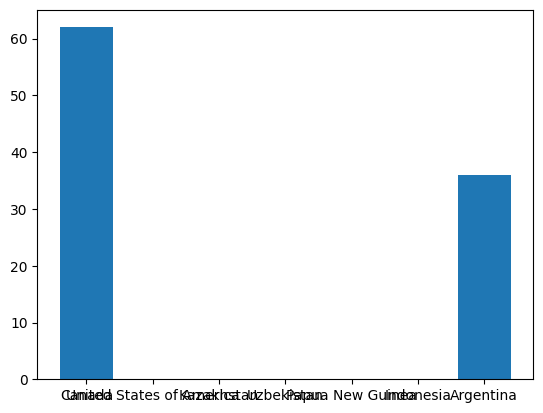

In [9]:
# Merge
merged = world.merge(dataframe[[args_code_col, args_value_col]], left_on=CODE_COLUMN, right_on=args_code_col, how="left")
num_of_plot_elems = 10
plt.bar(merged["SOVEREIGNT"][:num_of_plot_elems], merged["value"][:num_of_plot_elems])

In [ ]:
# Projection
merged = merged.to_crs(PROJECTIONS.get(USED_PROJECTION))

In [11]:
# try fix Bad Allocation error

# 1) simplify data
merged["geometry"] = merged["geometry"].simplify(0.55, preserve_topology=True)

# 2) fix corrupt data
merged = merged[merged.is_valid]
merged = merged.explode(index_parts=False, ignore_index=True)  # flatten MultiPolygons

# 3) make plotting easier
#import matplotlib
#matplotlib.use("QtAgg")  # non-interactive, memory safer

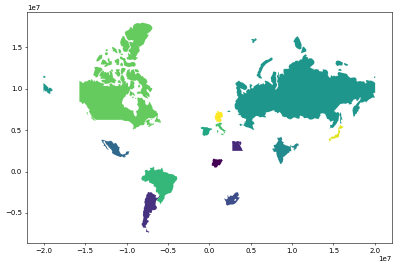

In [14]:
# Plot

fig = plt.figure(figsize=(12, 6), dpi=50)
ax = plt.gca()
fig.patch.set_alpha(0)

plot_kwargs = dict(
    column=args_value_col,
    cmap=args_cmap,
    linewidth=args_edge_width,
    edgecolor=args_edge_color,
    missing_kwds={"color": args_missing_color, "edgecolor": args_edge_color, "hatch": None, "linewidth": args_edge_width},
)
#merged.plot(ax=ax, **plot_kwargs)
merged.plot(column="value", ax=ax, cmap=args_cmap)
plt.show()

In [10]:
print(merged.geometry.apply(lambda g: g.__sizeof__()).sort_values(ascending=False).head())


286    40
0      40
1      40
2      40
3      40
Name: geometry, dtype: int64


# Country names in datasets

In [13]:
world = load_world()
#print(world["SOVEREIGNT"])
for _, row in world.iterrows():
    print(row["SOVEREIGNT"])

Fiji
United Republic of Tanzania
Western Sahara
Canada
United States of America
Kazakhstan
Uzbekistan
Papua New Guinea
Indonesia
Argentina
Chile
Democratic Republic of the Congo
Somalia
Kenya
Sudan
Chad
Haiti
Dominican Republic
Russia
The Bahamas
United Kingdom
Norway
Denmark
France
East Timor
South Africa
Lesotho
Mexico
Uruguay
Brazil
Bolivia
Peru
Colombia
Panama
Costa Rica
Nicaragua
Honduras
El Salvador
Guatemala
Belize
Venezuela
Guyana
Suriname
France
Ecuador
United States of America
Jamaica
Cuba
Zimbabwe
Botswana
Namibia
Senegal
Mali
Mauritania
Benin
Niger
Nigeria
Cameroon
Togo
Ghana
Ivory Coast
Guinea
Guinea-Bissau
Liberia
Sierra Leone
Burkina Faso
Central African Republic
Republic of the Congo
Gabon
Equatorial Guinea
Zambia
Malawi
Mozambique
eSwatini
Angola
Burundi
Israel
Lebanon
Madagascar
Israel
Gambia
Tunisia
Algeria
Jordan
United Arab Emirates
Qatar
Kuwait
Iraq
Oman
Vanuatu
Cambodia
Thailand
Laos
Myanmar
Vietnam
North Korea
South Korea
Mongolia
India
Bangladesh
Bhutan
Nepal
P